# Molecular Dynamics Assignment

In [1]:
import scipy as s
import numpy as np
import matplotlib.pyplot as plt
import time
import numba
from numba import jit
import re
import math

In [2]:
# Define all the necessary functions
@jit(nopython = True)
def LJ_real(sigma, epsi, r):
    Energy = 4*epsi*((sigma/r)**12-(sigma/r)**6);
    return Energy;

    
# Defining function to calculate the d(U)/dr * r

@jit(nopython = True)
def Dudr (sigma, epsi, r):
    Energy = -24*(epsi)*(2*(sigma/r)**12-(sigma/r)**6); # Calculation of the force // calculates fi*ri 
    return Energy;    

# function to perform the averages
@jit(nopython = True)
def averages(A):
    
    sum = 0;
    for i in range(len(A)):
        sum = sum +A[i-1];
    return (sum/len(A));     

# to define the writing file remember to tranpose my array before using this function.
def write_xyz_traj(r, Npart, file_name):
	'''
		This function appends a frame to the end of a xyz file. 
		
		: r : 			position of the particles in the form of [[x1,y1,z1],[x2,y2,z2] ... [xN,yN,zN]]
		: Npart :		number of particles (int)
		: filename :	name of the trajectory file where the frame gets appended (str)

	'''
	output_box0 = open(file_name + '.xyz', 'a')
	output_box0.write('%0.0i\n\n' % Npart)
	[output_box0.write('%s\t%0.5f\t%0.5f\t%0.5f\n' % ("C", r[i, 0], r[i, 1], r[i, 2])) for i in range(0, Npart)]
	output_box0.close()
 
def read_xyz_trj(file_name):

    xyz_file = open(file_name, 'r')

    frame = 0
    xyz = {}
    READING=True
    while READING:
        try:
            nparts = int(xyz_file.readline())
            xyz_file.readline()
            xyz[frame] = np.zeros([nparts, 3])
            for k in range(0, nparts):
                line = xyz_file.readline()
                line = line.split()
                xyz[frame][k, 0] = line[1]
                xyz[frame][k, 1] = line[2]
                xyz[frame][k, 2] = line[3]
            frame += 1
        except:
            print("Reach end of '" + file_name + "'")
            READING=False

    return xyz
    
    

In [29]:
def verifylog(filename):

    '''
    To read the KE, PE and all the other stuff in the lammps log file.
    '''
    inp_dat = open(filename,"r");

    count  = 0;
    coord_arr = [[],[],[],[],[],[]]; # Mega Array to Store all the Stuff.


    for line in inp_dat: 
    
        temp = line.split(); # to Segregate the coordinartes
        x = float(temp[0]);
        coord_arr[0].append(x);
        y = float(temp[1])
        coord_arr[1].append(y);
        z = float(temp[2]);
        coord_arr[2].append(z);
        a = float(temp[3]);
        coord_arr[3].append(a);
        b = float(temp[4]);
        coord_arr[4].append(b);  
        c = float(temp[5]);
        coord_arr[5].append(c);     # to Skip the first two lines as they dont have the trajectories.  
    
    return coord_arr 
    

In [30]:

def write_frame(coords, L, vels, forces, trajectory_name, step):
    '''
    function to write trajectory file in LAMMPS format

    output can be read in in VMD using the provided vis.vmd script using
    vmd -e vis.vmd
    You may need to adjust name of trajectory file in vis.vmd

    In VMD you can visualize the motion of particles.


    :param coords: coordinates
    :param vels: velocities
    :param forces: forces
    :param trajectory_name: trajectory filename

    :return:
    '''

    nPart = len(coords[:, 0])
    nDim = len(coords[0, :])
    with open(trajectory_name, 'a') as file:
        file.write('ITEM: TIMESTEP\n')
        file.write('%i\n' % step)
        file.write('ITEM: NUMBER OF ATOMS\n')
        file.write('%i\n' % nPart)
        file.write('ITEM: BOX BOUNDS pp pp pp\n')
        for dim in range(nDim):
            file.write('%.6f %.6f\n' % (-0.5 * L[dim], 0.5 * L[dim]))
        for dim in range(3 - nDim):
            file.write('%.6f %.6f\n' % (0, 0))
        file.write('ITEM: ATOMS id type xu yu zu vx vy vz fx fy fz\n')

        temp = np.zeros((nPart, 9))
        for dim in range(nDim):
            temp[:, dim] = coords[:, dim]
            temp[:, dim + 3] = vels[:, dim]
            temp[:, dim + 6] = forces[:, dim]

        for part in range(nPart):
            file.write('%i %i %.4f %.4f %.4f %.6f %.6f %.6f %.4f %.4f %.4f\n' % (part + 1, 1, *temp[part, :]))


In [31]:
def write_xyz_traj(r, Npart, file_name):
	'''
		This function appends a frame to the end of a xyz file. 
		
		: r : 			position of the particles in the form of [[x1,y1,z1],[x2,y2,z2] ... [xN,yN,zN]]
		: Npart :		number of particles (int)
		: filename :	name of the trajectory file where the frame gets appended (str)

	'''
	output_box0 = open(file_name + '.xyz', 'a')
	output_box0.write('%0.0i\n\n' % Npart)
	[output_box0.write('%s\t%0.5f\t%0.5f\t%0.5f\n' % ("C", r[i, 0], r[i, 1], r[i, 2])) for i in range(0, Npart)]
	output_box0.close()

In [32]:
def rdf(xyz, LxLyLz, n_bins=100, r_range=(0.01, 10.0)):
    '''
    rarial pair distribution function

    :param xyz: coordinates in xyz format per frame
    :param LxLyLz: box length in vector format
    :param n_bins: number of bins
    :param r_range: range on which to compute rdf
    :return:
    '''

    g_r, edges = np.histogram([0], bins=n_bins, range=r_range)
    g_r[0] = 0
    g_r = g_r.astype(np.float64)
    rho = 0

    for i, xyz_i in enumerate(xyz):
        xyz_j = np.vstack([xyz[:i], xyz[i + 1:]])
        d = np.abs(xyz_i - xyz_j)
        d = np.where(d > 0.5 * LxLyLz, LxLyLz - d, d)
        d = np.sqrt(np.sum(d ** 2, axis=-1))
        temp_g_r, _ = np.histogram(d, bins=n_bins, range=r_range)
        g_r += temp_g_r

    rho += (i + 1) / np.prod(LxLyLz)
    r = 0.5 * (edges[1:] + edges[:-1])
    V = 4./3. * np.pi * (np.power(edges[1:], 3) - np.power(edges[:-1], 3))
    norm = rho * i
    g_r /= norm * V

    return r, g_r


In [33]:
def read_lammps_trj(lammps_trj_file):

    def read_lammps_frame(trj):
        """Load a frame from a LAMMPS dump file.

        Args:
            trj (file): LAMMPS dump file of format 'ID type x y z' or
                                                   'ID type x y z vx vy vz' or
                                                   'ID type x y z fz'
            read_velocities (bool): if True, reads velocity data from file
            read_zforces (bool): if True, reads zforces data from file

        Returns:
            xyz (numpy.ndarray):
            types (numpy.ndarray):
            step (int):
            box (groupy Box object):
            vxyz (numpy.ndarray):
            fz (numpy.ndarray):
        """
        # --- begin header ---
        trj.readline()  # text "ITEM: TIMESTEP"
        step = int(trj.readline())  # timestep
        trj.readline()  # text "ITEM: NUMBER OF ATOMS"
        n_atoms = int(trj.readline())  # num atoms
        trj.readline()  # text "ITEM: BOX BOUNDS pp pp pp"
        Lx = trj.readline().split()  # x-dim of box
        Ly = trj.readline().split()  # y-dim of box
        Lz = trj.readline().split()  # z-dim of box
        L = np.array([float(Lx[1]) - float(Lx[0]),
                      float(Ly[1]) - float(Ly[0]),
                      float(Lz[1]) - float(Lz[0])])
        trj.readline()  # text
        # --- end header ---

        xyz = np.empty(shape=(n_atoms, 3))
        xyz[:] = np.NAN
        types = np.empty(shape=(n_atoms), dtype='int')
        vxyz = np.empty(shape=(n_atoms, 3))
        vxyz[:] = np.NAN
        fxyz = np.empty(shape=(n_atoms, 3))
        fxyz[:] = np.NAN

        # --- begin body ---

        IDs = []
        for i in range(n_atoms):
            temp = trj.readline().split()
            a_ID = int(temp[0]) - 0  # atom ID
            xyz[a_ID - 1] = [float(x) for x in temp[2:5]]  # coordinates
            types[a_ID - 1] = int(temp[1])  # atom type
            vxyz[a_ID - 1] = [float(x) for x in temp[5:8]]  # velocities
            fxyz[a_ID - 1] = [float(x) for x in temp[8:11]]  # map(float, temp[5]) # z-forces

        # --- end body ---
        return xyz, types, step, L, vxyz, fxyz


    xyz = {}
    vel = {}
    forces = {}
    with open(lammps_trj_file, 'r') as f:
        READING = True
        c = 0
        while READING:
            try:
                xyz[c], _, _, _, vel[c], forces[c] = read_lammps_frame(f)
                c += 1
            except:
                READING=False

    return xyz, vel, forces


### Part of Question 4:

In [34]:
# Defining the function for calculation of the total Potential energy
@jit(nopython = True)
def Etot (Natom, sigma, epsi, traj, Rcut, Lx, Ly, Lz): 
    '''
    Calculates the total energy of a frame. function nameis kept different from the one in the assignment (totalEnergy).
    
    param:
    Natom: total atoms
    sigma, eplsilon are written as sigma and epsi 
    traj: particle trajectory for the frame.
    box dimenstions as Lx, Ly and Lz.
    Rcut is cutoff radius
    
    output:
    gives the energy of the system as same units as epslion.
    '''
    
    U_adder = 0;  # to store the Total Energy Computed

 # Now setting up a loop for computing nC2 combinations.

    for i in range(0,Natom-1):  
        
        for j in range(i+1,Natom):
            
    # we store the values of the the trajectores of the two atoms in z=x, y, z so that it is more convinient to write the code
    # although it uses up a lot of the space for the Memory.
                  
            x1 = traj[0][i];
            y1 = traj[1][i];
            z1 = traj[2][i];
            
     # Similarly we put for atom 2
            
            x2 = traj[0][j];
            y2 = traj[1][j];
            z2 = traj[2][j];  
            
  # Getting done with the PBC Stuff

            tr2 = np.array([x2, y2, z2]);
            tr1 = np.array([x1, y1, z1]);
            dist = np.abs(tr2 - tr1);
            lxlylz = np.array([Lx, Ly, Lz]);
            dist = np.where(dist > 0.5 * lxlylz, lxlylz - dist, dist);
        
    # now we calculate the Distance between the two particles
            
            R = (dist[0]**2 + dist[1]**2 + dist[2]**2)**0.5;
            
    #  Apply the Cutoff Radius Method  and shift the energy potentials properly so that they are no discontinuous.  
        
            if (R <= Rcut):
                
                U_adder = U_adder + LJ_real(sigma,epsi,R) ;  # Tail correction factor is an approximation

        U_adder = U_adder + (Natom/(Lx*Ly*Lz))*8/3*np.pi*epsi*(sigma**3)*(1/3*(sigma/Rcut)**9 - (sigma/Rcut)**3);
    return U_adder;



In [35]:
# Defining all the necessary constants
Kb = 1.38*10**-23;
eps = 1.7*10**-21;
R = 8.314;
Ang = 10**-10;
Na = 6.022*10**23

## Part 1: 

#### Question 1.1:


In [36]:
# Create a initial grid

def initGrid( Natom, Lx, Ly, Lz):
    '''
    the rows are the xyz coordinates and the columns are the atoms. To bring to the standard format 
    with xyz in columns and atoms in rows please use .transpose() after the array variable. eg: a.transpose(); 
    '''
    a = Lx*Ly*Lz/Natom;
    cell_length = a**(1/3);
  
    px = round(Lx/cell_length);
    py = round(Ly/cell_length);
    
    cell_length = Lx/(px+1); 
    
    # to ensure that atleast (sigma) distance is maintained between atoms
    if (py >= 9):
        py = py-1; 
    if (px >= 9):
        px = px-1;
    
    coord_arr = np.zeros((3,Natom))
    count = 0;
    cx = 0;
    cy = 0;
    cz = 0;
    
    while(count<= Natom):
        if (count >= Natom):
            break;
        for i in range(0, py+1):
            
            for j in range(0, px+1): 
                if (count >= Natom):
                    break;
                coord_arr[0][count] =  j*cell_length;
                coord_arr[1][count] =  i*cell_length;
                coord_arr[2][count] =  cz*cell_length;
                count+= 1;
        cz +=1;
    '''
    The coordinates that have been created are from 0 to 30 ang in x,y,z direction.
    now we shift it to half the max distance that an atom is place from the origin along each axis.
    so 0 to 30 angsrom becomes -15  to 15 angstrom  along each axis
    
    '''
    
    translatex = np.max(coord_arr[0])/2;    
    translatey = np.max(coord_arr[1])/2; 
    translatez = np.max(coord_arr[2])/2; 
    coord_arr[0] = coord_arr[0] - (translatex)*np.ones((1, Natom));
    coord_arr[1] = coord_arr[1] - (translatey)*np.ones((1, Natom));
    coord_arr[2] = coord_arr[2] - (translatez)*np.ones((1, Natom));
    return coord_arr


Reach end of 'develop_box_362.xyz'


Text(0.5,1,'RDF for 362 particles')

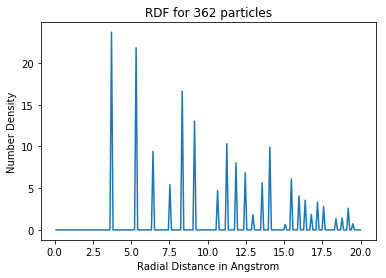

In [46]:
# case1: Number of particles = 362
a1 = initGrid( 362, 30, 30, 30);

# Create the RDF of the system.
write_xyz_traj(a1.transpose(), 362, 'develop_box_362');

count  = 0;
xyzd = read_xyz_trj('develop_box_362.xyz') 
#number of bins to use for rdf
    
nbins = 199
gr2 = np.zeros(nbins)
# box lenghts as a vector
L = np.array([30,30,30])
# limits to calculate the rdf
rdf_range = (0.10, 20.0)
# loop through frames
for key in xyzd.keys():
    r, temp = rdf(xyzd[key], L, nbins, rdf_range)
    gr2 += temp
    count +=1
        
    gr2 /= len(xyzd.keys());

# Print the RDF of the system   
plt.plot(np.linspace(0.1,20,199),gr2); 
plt.xlabel("Radial Distance in Angstrom")
plt.ylabel("Number Density")
plt.title("RDF for 362 particles")

Reach end of 'develop_box_181.xyz'


Text(0.5,1,'RDF for 181 particles')

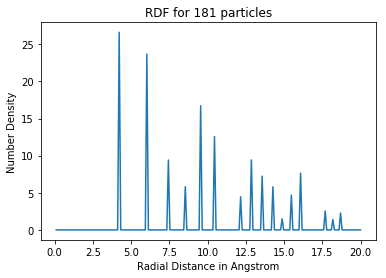

In [44]:
# particles = 181
a2 = initGrid( 181, 30, 30, 30);

# Create the RDF of the system.
write_xyz_traj(a2.transpose(), 181, 'develop_box_181');
count  = 0;
xyzd = read_xyz_trj('develop_box_181.xyz') 
#number of bins to use for rdf
    
nbins = 199
gr2 = np.zeros(nbins)
# box lenghts as a vector
L = np.array([30,30,30])
# limits to calculate the rdf
rdf_range = (0.10, 20.0)
# loop through frames
for key in xyzd.keys():
    r, temp = rdf(xyzd[key], L, nbins, rdf_range)
    gr2 += temp
    count +=1
        
    gr2 /= len(xyzd.keys());

# Print the RDF of the system   
plt.plot(np.linspace(0.1,20,199),gr2);   
plt.xlabel("Radial Distance in Angstrom")
plt.ylabel("Number Density")
plt.title("RDF for 181 particles")

Reach end of 'develop_box_724.xyz'


Text(0.5,1,'RDF for 724 particles')

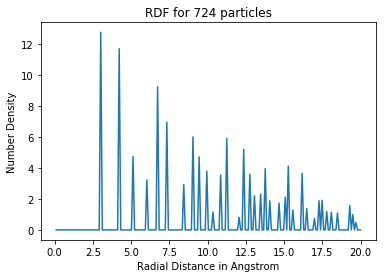

In [14]:
# particles = 724
a2 = initGrid( 724, 30, 30, 30);

# Create the RDF of the system.
write_xyz_traj(a2.transpose(), 724, 'develop_box_724');
count  = 0;
xyzd = read_xyz_trj('develop_box_724.xyz') 
#number of bins to use for rdf
    
nbins = 199
gr2 = np.zeros(nbins)
# box lenghts as a vector
L = np.array([30,30,30])
# limits to calculate the rdf
rdf_range = (0.10, 20.0)
# loop through frames
for key in xyzd.keys():
    r, temp = rdf(xyzd[key], L, nbins, rdf_range)
    gr2 += temp
    count +=1
        
    gr2 /= len(xyzd.keys());

# Print the RDF of the system   
plt.plot(np.linspace(0.1,20,199),gr2);  
plt.xlabel("Radial Distance in Angstrom")
plt.ylabel("Number Density")
plt.title("RDF for 724 particles")


### Question 1.2

In [37]:
@jit (nopython =True)
def initvelocity(Natom, T, M):
    '''
    Creates random initial velocities
    
    params:
    Natom: Number of Atoms
    T: Temperature in Kelvin
    M: Mass in Gm/mol
    
    Outputs:
    Velocity array in(m/s).
    '''
    sumvx = 0;
    sumvy = 0;
    sumvz = 0;
    
    sumv2x = 0;
    sumv2y = 0;
    sumv2z = 0;
    
    velarr = np.random.rand(3, Natom);
    velarr = velarr - 0.5* np.ones((3, Natom));
    
    for i in range(0, Natom):
        sumvx = sumvx + velarr[0][i];
        sumvy = sumvy + velarr[1][i];
        sumvz = sumvz + velarr[2][i];
        
        sumv2x = sumv2z + (velarr[0][i])**2;
        sumv2y = sumv2z + (velarr[1][i])**2;
        sumv2z = sumv2z + (velarr[2][i])**2;
        
    # rescale the velocities
    scalex = np.sqrt(R*T/(sumv2x)*(Natom*1000)/M);
    scaley = np.sqrt(R*T/(sumv2y)*(Natom*1000)/M)
    scalez = np.sqrt(R*T/(sumv2z)*(Natom*1000)/M)
    
    
    for i in range(0, Natom):
        
        velarr[0][i] = scalex*(velarr[0][i] - sumvx/Natom);  
        velarr[1][i] = scaley*(velarr[1][i] - sumvy/Natom);
        velarr[2][i] = scalez*(velarr[2][i] - sumvz/Natom);
    
        
    return velarr;


### Question 2.1 and 2.2

In [38]:
@jit(nopython = True)
def forces1(Natom, sigma, epsi,Traj,Lx, Ly, Lz, Rcut,M, T): #  Calculates -Du/Dr
    
    '''
    param:
    Natom number of atoms
    sigma 3.73
    epsi in Kelvin
    Traj : traj for which the force should be calculated; use my previous format (rows as xyz and columns as particle);
    Lx, Ly, Lz in angstrom
    mass in gm /mol
    Rcut is cutoff radius
    T: temperature in Kelvin 
    
    Output:
    Prssure of the frame (in Pascals)
    Acceleration array (in SI units).
    
    '''
    U_adder = 0;
    traj = Traj;
    ff = np.zeros((3,Natom));
    
    for i in range(0, Natom-1):
        for j in range(i+1,Natom):
                       
            x1 = traj[0][i];
            y1 = traj[1][i];
            z1 = traj[2][i];
            
     # Similarly we put for atom 2
            
            x2 = traj[0][j];
            y2 = traj[1][j];
            z2 = traj[2][j];
            
   # Getting done with the PBC Stuff

            x = (x2 - x1) - Lx*np.round((x2 - x1)/Lx);   # for dx = dx - nearest_int(dx/L)
            y = (y2 - y1) - Ly*np.round((y2 - y1)/Ly);
            z = (z2 - z1) - Lz*np.round((z2 - z1)/Lz); 
            
    # now we calculate the Distance between the two particles 

    
    
            r = np.sqrt(x**2 + y**2 + z**2);    
            if ( r <= Rcut):
                
             
                ftot = (24/r**2)*epsi*(sigma/r)**6*(2*(sigma/r)**6-1);  #-dU/Dr

                # Update the force Array
            
                ff[0][i] = ff[0][i] - (x)*(ftot)   # update the reference particle
                ff[1][i] = ff[1][i] - (y)*(ftot)
                ff[2][i] = ff[2][i] - (z)*(ftot)
                
                ff[0][j] = ff[0][j] + (x)*(ftot)   # update the other particle
                ff[1][j] = ff[1][j] + (y)*(ftot)
                ff[2][j] = ff[2][j] + (z)*(ftot)
                
                U_adder = U_adder + Dudr(sigma,epsi,r);
    
    P_reduced = Natom/(Lx*Ly*Lz)*(T)- 1/(3*Lx*Ly*Lz)*((U_adder));  #  1 is taken as epsion is Kelvin and not joules '-' sign is taen cae in the function definition
    P_Pascal = P_reduced*Kb/(10**-30);  
    
    
    ff = ff*Kb/(Ang); # to caulate the force in Newton.
    
    acc = ff*(1000/M*Na); # acc in m/s2
    
    return P_Pascal,  acc;


### Part of Question 4:

In [22]:
@jit (nopython = True)
def kinetic(Natom,v):
    '''
    Computes the inetic energy from the velocities of the particles
    
    Params:
    Number of atoms
    velocity array
    
    
    output:
    Temperature in Kelvin
    KE in Joules
    '''
    
    sumvx = 0;
    sumvy = 0;
    sumvz = 0;
    
    sumv2x = 0;
    sumv2y = 0;
    sumv2z = 0;
    
    for i in range(0, Natom):
            sumvx = sumvx + v[0][i];
            sumvy = sumvy + v[1][i];
            sumvz = sumvz + v[2][i];
        
            sumv2x = sumv2z + (v[0][i])**2;
            sumv2y = sumv2z + (v[1][i])**2;
            sumv2z = sumv2z + (v[2][i])**2;
        
    
    T = (16.04*10**-3*(sumv2x+sumv2y+sumv2z)/Natom/(3*R));
    KE = 0.5*(3*Natom+1)* Kb* T;  
    
    return KE, T

### Question 3:

In [39]:

def verlet(Natom, sigma,epsi, M, Lx, Ly, Lz, Rcut, inittraj, initvel, t, steps, T):
    '''
    Performs the verlet integration
    
    param
    Natom: No of atoms
    sigma:sigma
    epsi:epsilon
    M: Mass in gm per mol
    Lx Ly Lz: Box dims
    Rcut: Cutoff
    inittraj: initial trajectory
    initvel: initial velocities
    t: time step size (femto sec for our simulation)
    step: MD ccycle
    T: Temperature
    
    Outputs:
    T, P, (Kelvin and Pascals)
    KE in Joules 
    PE in Kelvin
    '''
    KE = np.zeros((1, steps));
    PE = np.zeros((1, steps));
    T = np.zeros((1, steps));
    P = np.zeros((1, steps));
    trajo = inittraj;
    v = initvel;
    sumvx = 0;
    sumvy = 0;
    sumvz = 0;
    
    sumv2x = 0;
    sumv2y = 0;
    sumv2z = 0;
    
    acc_new = forces1(Natom, sigma, epsi, trajo ,Lx, Ly, Lz, Rcut, M, T);
    

    
    for i in range(0, steps):
        
        for k in range(0, Natom):
            v[0][k] = v[0][k] + (acc_new[1][0][k])/2*t;
            v[1][k] = v[1][k] + (acc_new[1][1][k])/2*t;
            v[2][k] = v[2][k] + (acc_new[1][2][k])/2*t;
        
        
        for k in range(0, Natom):
            trajo[0][k] = trajo[0][k] + v[0][k]*t*(1e+10);  
            trajo[1][k] = trajo[1][k] + v[1][k]*t*(1e+10); 
            trajo[2][k] = trajo[2][k] + v[2][k]*t*(1e+10); 
         
   
        acc_new = forces1(Natom, sigma, epsi, trajo ,Lx, Ly, Lz, Rcut, M , T);
        

        # Store the pressure
        P[0][i] = (acc_new[0][0][0]);
            
        for k in range(0, Natom):
          
            v[0][k] = v[0][k] + (acc_new[1][0][k])/2*t;
            v[1][k] = v[1][k] + (acc_new[1][1][k])/2*t;
            v[2][k] = v[2][k] + (acc_new[1][2][k])/2*t;
        
        # Put the partices back into the box
        
        for j in range(0, Natom):
            
            if (trajo[0][j] > Lx/2):
                trajo[0][j] = trajo[0][j] - Lx;
                
        
            if (trajo[0][j] < -Lx/2):
                trajo[0][j] = trajo[0][j] + Lx;
                
            if (trajo[1][j] > Ly/2):
                trajo[1][j] = trajo[1][j] - Lx;
            
            if (trajo[1][j] < -Ly/2):
                trajo[1][j] = trajo[1][j] + Lx;
                
            if (trajo[2][j] > Lz/2):
                trajo[2][j] = trajo[2][j] - Lx;   
                
            if (trajo[2][j] < -Lz/2):
                trajo[2][j] = trajo[2][j] + Lx; 
    
        a = kinetic(Natom, v);
        T[0][i]  = a[1];
        KE[0][i] = a[0];
        PE[0][i] = Etot (Natom, sigma, epsi, trajo, Rcut, Lx, Ly, Lz); 
        
        
    return T, P, KE, PE      

### Question 5: (Note: log file of LAMMPS is needed for comparision which I have uploaded)

In [169]:
start = initGrid(362, 30, 30 ,30);

In [170]:
iv = initvelocity(362,150, 16.04);

In [171]:
stat0 = verlet(362, 3.73, 148, 16.04, 30, 30, 30, 14, start, iv, 1e-15, 10000, 150);

In [192]:
comp_P_0 = [];
comp_T_0 = [];
comp_KE_0 = [];
comp_PE_0 = [];
comp_TE_0 = [];

for i in range (0, 10000):
    if (i%100 == 0):
        comp_P_0.append(stat0[1][0][i]);
        comp_T_0.append(stat0[0][0][i]);
        comp_KE_0.append(stat0[2][0][i]/Kb);
        comp_PE_0.append(stat0[3][0][i]);
        comp_TE_0.append((stat0[2][0][i]/Kb + stat0[3][0][i])); 
    
comp_P_0 = np.array(comp_P_0);    
comp_T_0 = np.array(comp_T_0);      
comp_KE_0 = np.array(comp_KE_0);
comp_PE_0 = np.array(comp_PE_0);
comp_TE_0 = np.array(comp_TE_0);   

In [193]:
# read data from the log file that I have uploaded with the assignment
verify1 = verifylog("logverify1.dat");

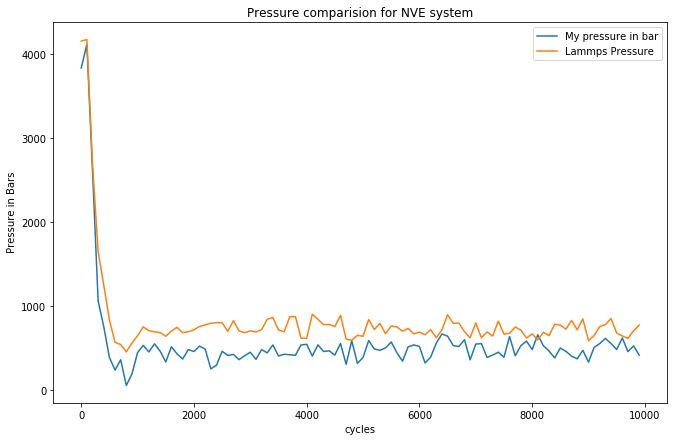

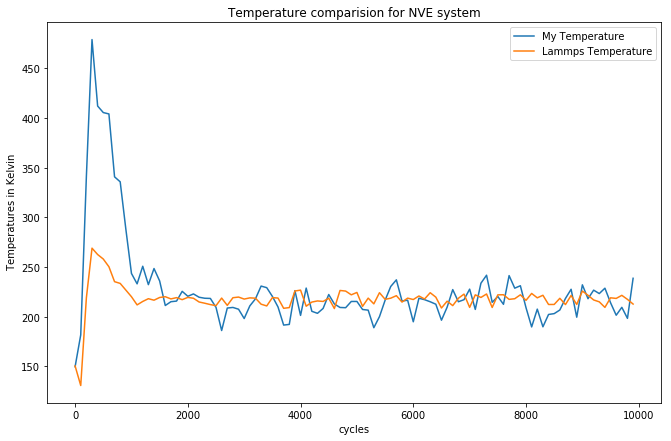

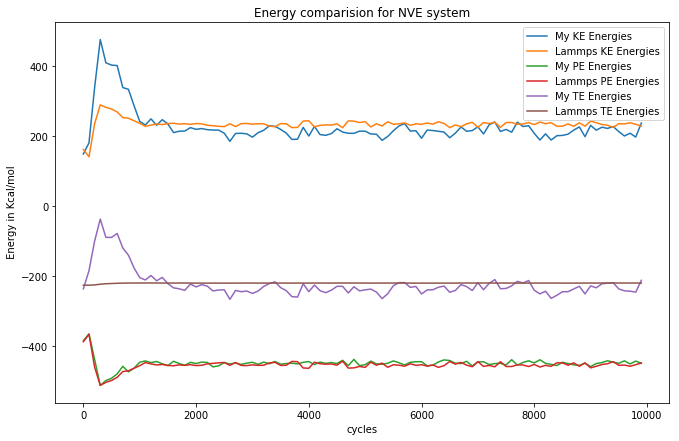

In [200]:
plt.figure( figsize  = (11,7));
plt.plot(verify1[0][0:100], comp_P_0/100000, label = "My pressure in bar");
plt.plot(verify1[0][0:100], verify1[2][0:100], label = "Lammps Pressure");
plt.title("Pressure comparision for NVE system");
plt.ylabel(" Pressure in Bars")
plt.xlabel("cycles")
plt.legend();

plt.figure(figsize  = (11,7));
plt.plot(verify1[0][0:100], comp_T_0, label = "My Temperature");
plt.plot(verify1[0][0:100], verify1[1][0:100], label = "Lammps Temperature");
plt.title("Temperature comparision for NVE system");
plt.ylabel(" Temperatures in Kelvin")
plt.xlabel("cycles")
plt.legend();


plt.figure(figsize  = (11,7));
plt.plot(verify1[0][0:100], comp_KE_0*Kb*Na/(3*4.18*362), label = "My KE Energies");
plt.plot(verify1[0][0:100], verify1[3][0:100], label = "Lammps KE Energies");
plt.plot(verify1[0][0:100], comp_PE_0*Kb*Na/(3*4.18*362), label = "My PE Energies");
plt.plot(verify1[0][0:100], verify1[4][0:100], label = "Lammps PE Energies");
plt.plot(verify1[0][0:100], comp_TE_0*Kb*Na/(3*4.18*362), label = "My TE Energies");
plt.plot(verify1[0][0:100], verify1[5][0:100], label = "Lammps TE Energies");
plt.title("Energy comparision for NVE system");
plt.ylabel(" Energy in Kcal/mol")
plt.xlabel("cycles")
plt.legend();


In [40]:
def velocityVerletThermostat(Natom, sigma,epsi, M, Lx, Ly, Lz, Rcut, inittraj, initvel, T, Q, t, steps, freq, filename):
    '''
    velocity verlet + nose hoover thermostat
    
    param:
    
    freq: writing frequency
    filename: writing file name (write a lammps trajectory file)
    
    ouputs:
    Avg_p: average pressure
    Avg_T: average temperature
    pressure array (pascals)
    Kinetic energy array (Joules)
    Potential energy array (Kelvin)

    '''
    #~~~~~~~~~~~~~Some initialisations~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                             
    KE = np.zeros((1, steps));
    PE = np.zeros((1, steps));
    Temperature = np.zeros((1, steps));
    Pressure = np.zeros((1, steps));
                             
    trajo = inittraj;
    v = initvel;  
    KEref  =  0.5*(3*Natom+1)* Kb* T;     
   
    # Calculate the initial damping parameter
    damp = 0;
    a = kinetic(Natom, v);
    damp  = damp + 0.5*t/Q*(a[0] - KEref);
                             
    # initial Forces
    acc_new = forces1(Natom, sigma, epsi, trajo ,Lx, Ly, Lz, Rcut, M, T );
                            
 #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~                            
                             
    for i in range(0, steps):
        
        a = kinetic(Natom, v);
        Temperature[0][i] = a[1];                     
        KE[0][i] = a[0];
        PE[0][i] = Etot (Natom, sigma, epsi, trajo, Rcut, Lx, Ly, Lz);
                        
        
        # update trajectory
        for k in range(0, Natom):
            trajo[0][k] = trajo[0][k] + v[0][k]*t*(1e+10) + (acc_new[1][0][k] - damp*v[0][k])/2*t*t*(1e+10)
            trajo[1][k] = trajo[1][k] + v[1][k]*t*(1e+10) + (acc_new[1][0][k] - damp*v[0][k])/2*t*t*(1e+10)
            trajo[2][k] = trajo[2][k] + v[2][k]*t*(1e+10) + (acc_new[1][0][k] - damp*v[0][k])/2*t*t*(1e+10)
                             
        # damp for half the time step                     
        a = kinetic(Natom, v);                     
        damp  = damp + 0.5*t/Q*(a[0] - KEref);                      
                                     
        # update the velocity with the damp for half the time step (remove the inital damp )                  
        for k in range(0, Natom):
                             
            v[0][k] = v[0][k] + (acc_new[1][0][k] - damp*v[0][k])/2*t;
            v[1][k] = v[1][k] + (acc_new[1][1][k] - damp*v[1][k])/2*t;
            v[2][k] = v[2][k] + (acc_new[1][2][k] - damp*v[2][k])/2*t;
        
       
            
        # Update the forces
        acc_new = forces1(Natom, sigma, epsi, trajo ,Lx, Ly, Lz, Rcut, M, T );
        
        # Store the pressure
        Pressure[0][i] = acc_new[0];
        
        # damp for a complete time step                     
        a = kinetic(Natom, v);                     
        damp  = damp + 0.5*t/(Q*Kb)*(a[0] - KEref);
            
        # use the full time step damp to update the velocity    
        for k in range(0, Natom):
                            
            v[0][k] = (v[0][k] + (acc_new[1][0][k])/2*t)/(1+ 0.5*damp);
            v[1][k] = (v[1][k] + (acc_new[1][1][k])/2*t)/(1+ 0.5*damp);
            v[2][k] = (v[2][k] + (acc_new[1][2][k])/2*t)/(1+ 0.5*damp);
        
        
        # Put the partices back into the box
        
        for j in range(0, Natom):
            
            if (trajo[0][j] > Lx/2):
                trajo[0][j] = trajo[0][j] - Lx;
            
            if (trajo[0][j] < -Lx/2):
                trajo[0][j] = trajo[0][j] + Lx;
                
            if (trajo[1][j] > Ly/2):
                trajo[1][j] = trajo[1][j] - Lx;
            
            if (trajo[1][j] < -Ly/2):
                trajo[1][j] = trajo[1][j] + Lx;
                
            if (trajo[2][j] > Lz/2):
                trajo[2][j] = trajo[2][j] - Lx;   
                
            if (trajo[2][j] < -Lz/2):
                trajo[2][j] = trajo[2][j] + Lx;     
        
        if (i%freq ==0):
            write_frame(trajo.transpose(), [Lx, Ly, Lz], v.transpose(), acc_new[1].transpose(), filename, i);
            
            
    avg_P = averages(Pressure[0]);
    avg_T = averages(Temperature[0]);
            
        
    return avg_P, avg_T,Pressure[0], Temperature[0], KE, PE;

    
    

### Question 6: Verify 2 (Note: Log file of LAMMPS needed for verification) 

In [43]:
start = initGrid(362, 30, 30 ,30);

In [44]:
iv = initvelocity(362, 150, 16.04);

In [45]:

stat3 = velocityVerletThermostat(362, 3.73,148, 16.04, 30, 30, 30, 14, start, iv, 150, 1e-9, 1e-15, 10000, 100, 'MD_150_368.4.lammps');


In [46]:
# read data from the log file that I have uploaded with the assignment
verify2 = verifylog("logverify2.dat");

In [48]:

comp_P = [];
comp_T = [];
comp_KE = [];
comp_PE = [];
comp_TE = [];

for i in range (0, 10000):
    if (i%100 == 0):
        comp_P.append(stat3[2][i]);
        comp_T.append(stat3[3][i]);
        comp_KE.append(stat3[4][0][i]/Kb);
        comp_PE.append(stat3[5][0][i]);
        comp_TE.append((stat3[4][0][i]/Kb + stat3[5][0][i])); 

comp_P = np.array(comp_P);    
comp_T = np.array(comp_T);      
comp_KE = np.array(comp_KE);
comp_PE = np.array(comp_PE);
comp_TE = np.array(comp_TE);

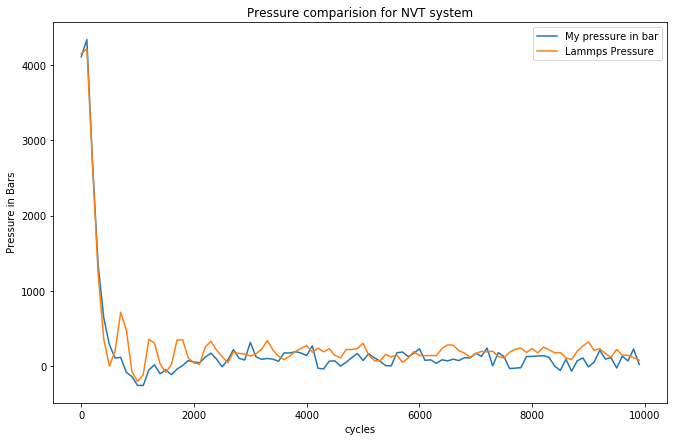

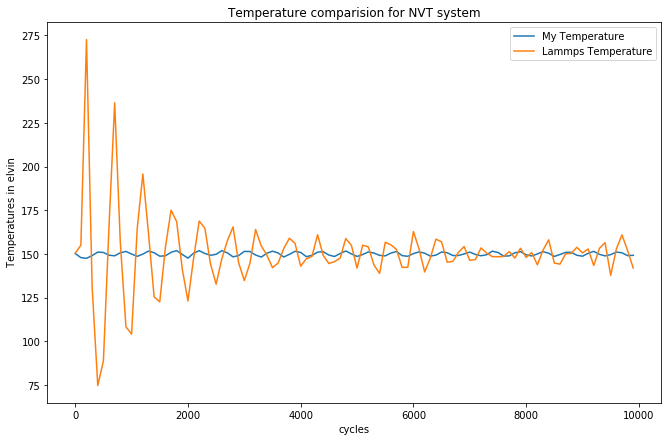

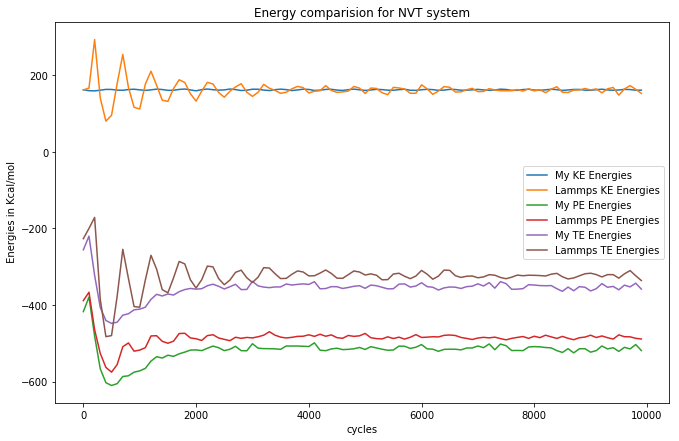

In [196]:
plt.figure( figsize  = (11,7));
plt.plot(verify2[0][0:100], comp_P/100000, label = "My pressure in bar");
plt.plot(verify2[0][0:100], verify2[2][0:100], label = "Lammps Pressure");
plt.title("Pressure comparision for NVT system");
plt.ylabel(" Pressure in Bars")
plt.xlabel("cycles")
plt.legend();

plt.figure(figsize  = (11,7));
plt.plot(verify2[0][0:100], comp_T, label = "My Temperature");
plt.plot(verify2[0][0:100], verify2[1][0:100], label = "Lammps Temperature");
plt.title("Temperature comparision for NVT system");
plt.ylabel(" Temperatures in elvin")
plt.xlabel("cycles")
plt.legend();


plt.figure(figsize  = (11,7));
plt.plot(verify2[0][0:100], comp_KE*R/(4.18*1000), label = "My KE Energies");
plt.plot(verify2[0][0:100], verify2[3][0:100], label = "Lammps KE Energies");
plt.plot(verify2[0][0:100], comp_PE*R/(4.2*1000), label = "My PE Energies");
plt.plot(verify2[0][0:100], verify2[4][0:100], label = "Lammps PE Energies");
plt.plot(verify2[0][0:100], comp_TE*R/(4.2*1000), label = "My TE Energies");
plt.plot(verify2[0][0:100], verify2[5][0:100], label = "Lammps TE Energies");
plt.title("Energy comparision for NVT system");
plt.ylabel(" Energies in Kcal/mol")
plt.xlabel("cycles")
plt.legend();


### Part 2:

#### Question 2.1:


In [96]:
start = initGrid(362, 30, 30 ,30);

In [97]:
iv = initvelocity(362, 150, 16.04);

In [98]:
# the standard deviation and the error in the energy (Fluctuations need to ne calculated)
t = time.time()
stat = velocityVerletThermostat(362, 3.73,148, 16.04, 30, 30, 30, 14, start, iv, 150, 1e-9, 1e-15, 10000, 100, 'MD_150_368.lammps');
print(time.time() - t);

999.7259404659271


In [99]:

print("average Temperature", stat[1]);
print("average Pressure", stat[0]/100000);

average Temperature 149.97933672776225
average Pressure 182.73288574901014


In [111]:
stat[3][0][1: len(stat[3][0])]

array([1.12400984e-18, 1.12427976e-18, 1.12402774e-18, ...,
       1.11981425e-18, 1.12060920e-18, 1.12148201e-18])

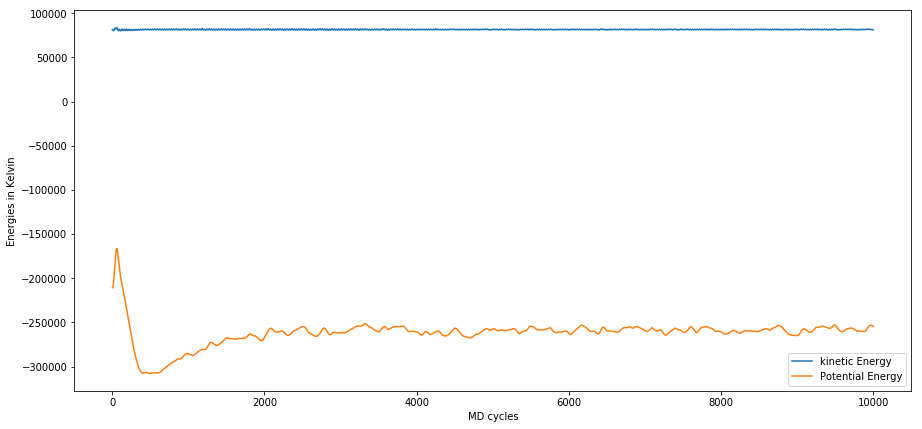

In [118]:
plt.figure(figsize = (15,7),)
plt.plot(np.linspace(1,len(stat[3][0]),(len(stat[3][0])-1)), stat[3][0][1: len(stat[3][0])]/Kb, ms = '1', label = "kinetic Energy" );
plt.plot(np.linspace(1,len(stat[4][0]),(len(stat[4][0])-1)), stat[4][0][1: len(stat[4][0])], ms = '1', label = "Potential Energy");
plt.xlabel("MD cycles");
plt.ylabel("Energies in Kelvin")
plt.legend( );

In [134]:
s = 0;
for i in range(0, len(stat[4][0])):
    s  += stat[4][0][i];
avg = s/(len(stat[4][0]));               

s = 0;
for i in range (len(stat[4][0])):
    s += (stat[4][0][i-1] - avg)**2

Std_Dev = np.sqrt(s/len(stat[4][0]));
print ("Average Potential energy in Kelvin is", avg);
print("Error is","+-",Std_Dev, " i.e.the standard deviation" );  

s = 0;
for i in range(0, len(stat[3][0])):
    s  += stat[3][0][i];
avg1 = s/(len(stat[3][0]));               

s = 0;
for i in range (len(stat[3][0])):
    s += (stat[3][0][i-1] - avg1)**2
    
Std_Dev1 = np.sqrt(s/len(stat[4][0]));
print ("Average KE energy in Kelvin is", avg1/Kb);
print("Error is","+-",Std_Dev1/Kb, " i.e.the standard deviation");

print("The Average Total Energy is " , avg + avg1/Kb);
print("The net error or st dev is ", Std_Dev + Std_Dev1/Kb);



Average Potential energy in Kelvin is -262237.3643073627
Error is +- 14808.642542166992  i.e.the standard deviation
Average KE energy in Kelvin is 81513.76951153876
Error is +- 402.80079227429064  i.e.the standard deviation
The Average Total Energy is  -262237.3643073627
The net error or st dev is  15211.443334441283


#### Question 2.2 (a)

(Note:After each calculation, pressure and the temperature will be displayed below the display cells. Manually update the values in the plot with these numbers.) 

#### Density = 358.4 

In [120]:
start1 = initGrid(362, 30 , 30 ,30);
iv1 = initvelocity(362, 100, 16.04);

In [121]:
#T = 100 density 358.4
t = time.time()
stat1= velocityVerletThermostat(362, 3.73,148, 16.04, 30, 30, 30, 14, start1, iv1, 100, 1e-9, 1e-15, 50000, 100, 'MD_100_358.4.lammps');
print(time.time() - t);

5557.8439111709595


In [124]:
print("Average temperature and pressure are", stat1[1], stat1[0]/100000);

Average temperature and pressure are 99.99166121419891 -321.48417465452155


In [135]:
#T = 200 density 358.4
start2 = initGrid(362, 30, 30 , 30);
iv2 = initvelocity(362, 200, 16.04);

In [136]:
t = time.time()
stat2= velocityVerletThermostat(362, 3.73,148, 16.04, 30, 30, 30, 14, start2, iv2,200, 1e-9, 1e-15, 50000, 100, 'MD_200_358.4.lammps');
print(time.time() - t);

4571.874103784561


In [138]:
print("Average temperature and pressure are", stat2[1], stat2[0]/100000);

Average temperature and pressure are 199.9819193779155 510.12789983721154


In [141]:
#T = 300 density 358.4
start3 = initGrid(362, 30, 30 ,30);
iv3 = initvelocity(362, 300, 16.04);

In [142]:
t = time.time()
stat3 = velocityVerletThermostat(362, 3.73,148, 16.04, 30, 30, 30, 14, start3, iv3, 300, 1e-9, 1e-15, 50000, 100, 'MD_300_358.4.lammps');
print(time.time() - t);

4594.501340150833


In [144]:
print("Average temperature and pressure are", stat3[1], stat3[0]/100000);

Average temperature and pressure are 299.9676707740235 1271.65024182674


In [145]:
#T = 400 density 358.4
start4 = initGrid(362, 30, 30, 30);
iv4 = initvelocity(362, 400, 16.04);

In [146]:
t = time.time()
stat4 = velocityVerletThermostat(362, 3.73,148,16.04, 30, 30, 30, 14, start4, iv4, 400, 1e-9, 1e-15, 50000, 100, 'MD_400_358.4.lammps');
print(time.time() - t);

4813.112359285355


In [149]:
print("Average temperature and pressure are", stat4[1], stat4[0]/100000);

Average temperature and pressure are 399.95041942830875 1944.287414549561


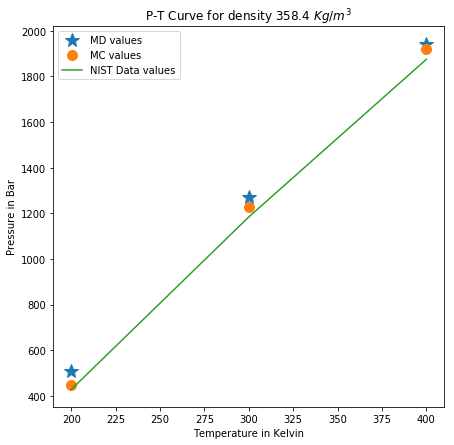

In [166]:

#Please see the values that are displayed and update the "MD values below for a fresh updated plot"  
plt.figure(3, figsize = (7,7));
plt.plot([ 200, 300, 400],[510.12, 1271.65, 1944.28], marker = "*", ms = 15, linestyle = '', label = "MD values");
plt.plot([ 200, 300, 400],[449, 1227, 1921], marker = "o", label = "MC values",ms = 10, linestyle = '');
plt.plot([ 200, 300, 400],[427.67, 1184, 1875], label = "NIST Data values");
plt.xlabel("Temperature in Kelvin");
plt.ylabel("Pressure in Bar");
plt.title("P-T Curve for density 358.4 $ Kg/m^3 $ ");
plt.legend();

#### Question 2.2 (b)
(Note:After each calculation, pressure and the temperature will be displayed below the display cells. Manually update the values in the plot with these numbers.) 

#### Density = 1.6

In [22]:
start5 = initGrid(362, 182, 182, 182);
iv5 = initvelocity(362, 100, 16.04);

In [23]:
t = time.time()
stat5 = velocityVerletThermostat(362, 3.73,148,16.04, 182, 182, 182, 50, start5, iv5, 100, 1e-9, 1e-15, 50000, 100, 'MD_100_1.6.lammps');
print(time.time() - t);

5011.569383382797


In [25]:
print("Average temperature and pressure are", stat5[1], stat5[0]/100000);

Average temperature and pressure are 99.99996420792353 0.8127745439830943


In [26]:
start6 = initGrid(362, 182, 182, 182);
iv6 = initvelocity(362, 200, 16.04);

In [27]:
t = time.time()
stat6 = velocityVerletThermostat(362, 3.73,148,16.04, 182, 182, 182, 50, start6, iv6, 200, 1e-9, 1e-15, 50000, 100, 'MD_200_1.6.lammps');
print(time.time() - t);

9471.711880207062


In [28]:
print("Average temperature and pressure are", stat6[1], stat6[0]/100000);

Average temperature and pressure are 199.9997699569951 1.6454240940030573


In [31]:
start7 = initGrid(362, 182, 182, 182);
iv7 = initvelocity(362, 300, 16.04);

In [32]:
t = time.time()
stat7 = velocityVerletThermostat(362, 3.73,148,16.04, 182, 182, 182, 50, start7, iv7, 300, 1e-9, 1e-15, 50000, 100, 'MD_300_1.6.lammps');
print(time.time() - t);

8200.240435361862


In [33]:
print("Average temperature and pressure are", stat7[1], stat7[0]/100000);

Average temperature and pressure are 299.99976508468893 2.4775262468839836


In [100]:
start8 = initGrid(362, 182, 182, 182);
iv8 = initvelocity(362, 400, 16.04);

In [101]:
t = time.time()
stat8 = velocityVerletThermostat(362, 3.73,148,16.04, 182, 182, 182, 50, start8, iv8, 400, 1e-9, 1e-15, 50000, 100, 'MD_400_1.6.lammps');
print(time.time() - t);

6788.867022275925


In [102]:
print("Average temperature and pressure are", stat8[1], stat8[0]/100000);

Average temperature and pressure are 399.99980577760505 3.3111243073094454


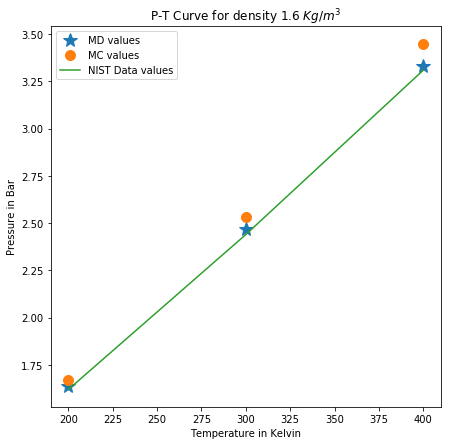

In [104]:
# Please update the new MD values manually 
plt.figure(4, figsize = (7,7));
plt.plot([ 200, 300, 400],[1.64, 2.47, 3.33], marker = "*", ms = 15, linestyle = '', label = "MD values");
plt.plot([ 200, 300, 400],[1.67, 2.53, 3.45], marker = "o", label = "MC values",ms = 10, linestyle = '');
plt.plot([ 200, 300, 400],[1.62, 2.44, 3.31], label = "NIST Data values");
plt.xlabel("Temperature in Kelvin");
plt.ylabel("Pressure in Bar");
plt.title("P-T Curve for density 1.6 $ Kg/m^3 $ ");
plt.legend();

## RDF

### Question No: 3 

In [65]:
# for density = 358.4

In [78]:
xyz1 = read_lammps_trj("MD_100_358.4.lammps")
#number of bins to use for rdf   
nbins = 149
gr1 = np.zeros(nbins)
# box lenghts as a vector
L = np.array([30 ,30, 30])
# limits to calculate the rdf
rdf_range = (0.1,15)
# loop through frames
for key in xyz1[0].keys():
    r, temp = rdf(xyz1[0][key], L, nbins, rdf_range)
    gr1 += temp

gr1 /= len(xyz1[0].keys())


xyz2 = read_lammps_trj("MD_200_358.4.lammps")
#number of bins to use for rdf   
nbins = 149
gr2 = np.zeros(nbins)
# box lenghts as a vector
L = np.array([30 ,30, 30])
# limits to calculate the rdf
rdf_range = (0.1,15)
# loop through frames
for key in xyz2[0].keys():
    r, temp = rdf(xyz2[0][key], L, nbins, rdf_range)
    gr2 += temp

gr2 /= len(xyz2[0].keys())




xyz3 = read_lammps_trj("MD_300_358.4.lammps")
#number of bins to use for rdf   
nbins = 149
gr3 = np.zeros(nbins)
# box lenghts as a vector
L = np.array([30 ,30, 30])
# limits to calculate the rdf
rdf_range = (0.1,15)
# loop through frames
for key in xyz3[0].keys():
    r, temp = rdf(xyz3[0][key], L, nbins, rdf_range)
    gr3 += temp

gr3 /= len(xyz3[0].keys())


xyz4 = read_lammps_trj("MD_400_358.4.lammps")
#number of bins to use for rdf   
nbins = 149
gr4 = np.zeros(nbins)
# box lenghts as a vector
L = np.array([30 ,30, 30])
# limits to calculate the rdf
rdf_range = (0.1,15)
# loop through frames
for key in xyz4[0].keys():
    r, temp = rdf(xyz4[0][key], L, nbins, rdf_range)
    gr4 += temp
gr4 /= len(xyz4[0].keys())



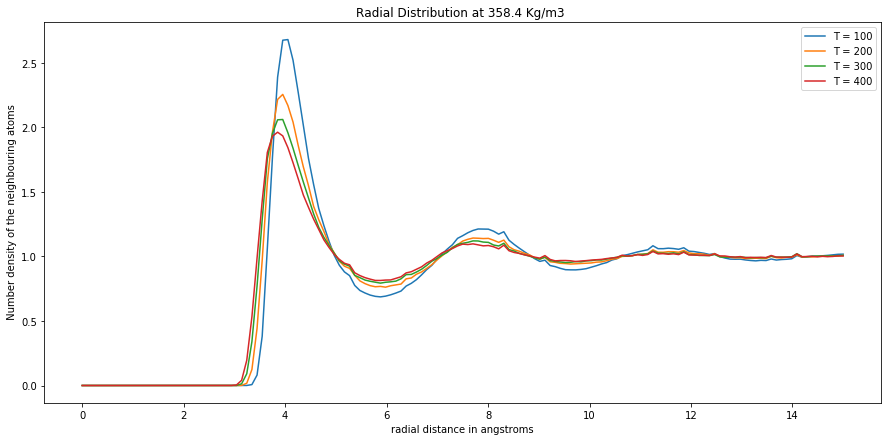

In [79]:
plt.figure(figsize =(15,7));
plt.plot(np.linspace(0,15,149),gr1, label  = "T = 100");
plt.plot(np.linspace(0,15,149),gr2, label  = "T = 200");
plt.plot(np.linspace(0,15,149),gr3, label  = "T = 300");
plt.plot(np.linspace(0,15,149),gr4, label  = "T = 400");

plt.xlabel("radial distance in angstroms")
plt.ylabel(" Number density of the neighbouring atoms");
plt.title("Radial Distribution at 358.4 Kg/m3 ");
plt.legend();

In [15]:
# For density = 1.6  

In [107]:

xyz11 = read_lammps_trj("MD_100_1.6.lammps")
#number of bins to use for rdf   
nbins = 199
gr11 = np.zeros(nbins)
# box lenghts as a vector
L = np.array([182 ,182, 182])
# limits to calculate the rdf
rdf_range = (0,80)
# loop through frames
for key in xyz11[0].keys():
    r, temp = rdf(xyz11[0][key], L, nbins, rdf_range)
    gr11 += temp

gr11 /= len(xyz11[0].keys())


xyz21 = read_lammps_trj("MD_200_1.6.lammps")
#number of bins to use for rdf   
nbins = 199
gr21 = np.zeros(nbins)
# box lenghts as a vector
L = np.array([182, 182, 182])
# limits to calculate the rdf
rdf_range = (0,80)
# loop through frames
for key in xyz21[0].keys():
    r, temp = rdf(xyz21[0][key], L, nbins, rdf_range)
    gr21 += temp
gr21 /= len(xyz21[0].keys())


xyz31 = read_lammps_trj("MD_300_1.6.lammps")
#number of bins to use for rdf   
nbins = 199
gr31 = np.zeros(nbins)
# box lenghts as a vector
L = np.array([182, 182, 182])
# limits to calculate the rdf
rdf_range = (0,80)
# loop through frames
for key in xyz31[0].keys():
    r, temp = rdf(xyz31[0][key], L, nbins, rdf_range)
    gr31 += temp
gr31 /= len(xyz31[0].keys())

xyz41 = read_lammps_trj("MD_400_1.6.lammps")
#number of bins to use for rdf   
nbins = 199
gr41 = np.zeros(nbins)
# box lenghts as a vector
L = np.array([182 ,182, 182])
# limits to calculate the rdf
rdf_range = (0,80)
# loop through frames
for key in xyz41[0].keys():
    r, temp = rdf(xyz41[0][key], L, nbins, rdf_range)
    gr41 += temp
gr41 /= len(xyz41[0].keys())


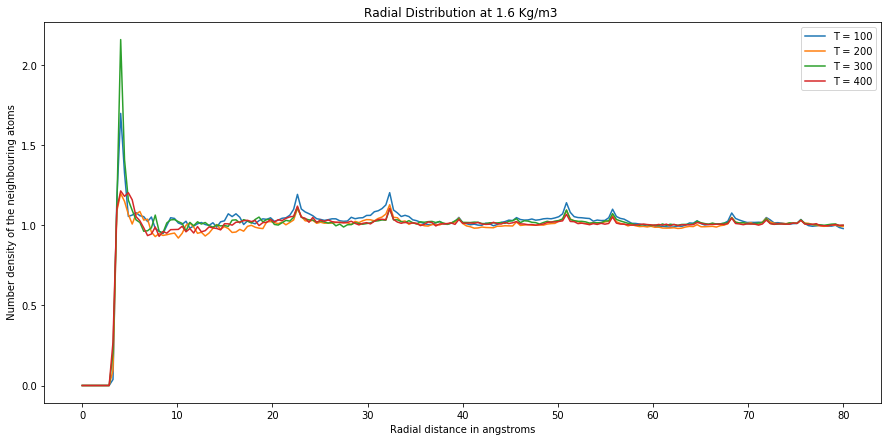

In [108]:
plt.figure(figsize =(15,7));
plt.plot(np.linspace(0,80,199),gr11, label  = "T = 100");
plt.plot(np.linspace(0,80,199),gr21, label  = "T = 200");
plt.plot(np.linspace(0,80,199),gr31, label  = "T = 300");
plt.plot(np.linspace(0,80,199),gr41, label  = "T = 400");

plt.xlabel("Radial distance in angstroms")
plt.ylabel(" Number density of the neighbouring atoms");
plt.title("Radial Distribution at 1.6 Kg/m3 ");
plt.legend();